In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Panel Data Version

### Panel Data of Rents

In [166]:
home_prices = pd.read_csv('../data/efz/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [167]:
home_prices = home_prices[home_prices.City == 'San Francisco']

In [168]:
annual = [c for c in home_prices.columns if '12-31' in c]

In [169]:
neighborhood_rents = home_prices[['RegionName'] + annual].copy()

In [170]:
neighborhood_rents.rename(columns={'RegionName': 'neighborhood'}, inplace=True)

In [171]:
covered_years = neighborhood_rents.columns[1:].str.split('-').str[0].astype(int) + 1

In [172]:
neighborhood_rents.columns = ['neighborhood'] + covered_years.tolist()

In [173]:
neighborhood_rents = neighborhood_rents.melt(id_vars='neighborhood', var_name='year', value_name='rent')

In [174]:
neighborhood_rents = neighborhood_rents[(neighborhood_rents.year >= 2007) & (neighborhood_rents.year < 2017)]

In [175]:
neighborhood_rents.neighborhood.nunique()

108

### Median sf per home per year in neighborhood

In [47]:
tax = gpd.read_feather('../data/tax.geofeather')

In [50]:
tax = tax[tax.closed_roll_year < 2017].copy()

In [64]:
residential = tax[tax.use_definition.str.contains('Residential') | False]

In [75]:
[c for c in residential.columns if 'unit' in c]

['number_of_units']

In [72]:
residential.analysis_neighborhood.nunique()

40

In [234]:
residential['home_size1'] = residential['property_area'] / residential['number_of_units']

In [235]:
sf_by_neighborhood = residential.groupby(['assessor_neighborhood', 'closed_roll_year']).agg({'home_size1':'median'})

In [236]:
sf_by_neighborhood = sf_by_neighborhood.reset_index()

In [237]:
sf_by_neighborhood.value_counts('assessor_neighborhood')

assessor_neighborhood
Alamo Square                 10
Anza Vista                   10
Pine Lake Park               10
Parnassus/Ashbury Heights    10
Parkside                     10
                             ..
Haight Ashbury               10
Stonestown                    9
Lake Shore                    9
Lakeside                      9
Merced Manor                  9
Name: count, Length: 82, dtype: int64

In [238]:
sf_by_neighborhood

,assessor_neighborhood,closed_roll_year,home_size1
0,Alamo Square,2007,1275.000000
1,Alamo Square,2008,1281.000000
2,Alamo Square,2009,1312.500000
3,Alamo Square,2010,1334.166667
4,Alamo Square,2011,1345.000000
...,...,...,...
811,Yerba Buena,2012,1187.500000
812,Yerba Buena,2013,1200.000000
813,Yerba Buena,2014,1200.000000
814,Yerba Buena,2015,1202.000000


In [239]:
residential.analysis_neighborhood.isin(neighborhood_rents.neighborhood).mean().round(2)

0.58

In [240]:
residential.assessor_neighborhood.isin(neighborhood_rents.neighborhood).mean().round(2)

0.96

In [241]:
neighborhood_rents.neighborhood.isin(residential.assessor_neighborhood).mean().round(2)

0.72

In [242]:
neighborhood_rents.neighborhood.isin(residential.analysis_neighborhood).mean()

0.23148148148148148

### Match Zillow neighborhoods with SF

In [243]:
residential = residential.replace({
    'assessor_neighborhood': {
        'Central Richmond': 'Inner Richmond',
        'Central Sunset': 'Inner Sunset',
        'Financial District North': 'Financial District',
        'Financial District South': 'Financial District',
        'Inner Parkside': 'Inner Sunset',
        'Outer Parkside': 'Outer Sunset'
}})

In [244]:
tax = tax.replace({
    'assessor_neighborhood': {
        'Central Richmond': 'Inner Richmond',
        'Central Sunset': 'Inner Sunset',
        'Financial District North': 'Financial District',
        'Financial District South': 'Financial District',
        'Inner Parkside': 'Inner Sunset',
        'Outer Parkside': 'Outer Sunset'
}})

In [245]:
neighborhood_rents = neighborhood_rents.replace(
    {'neighborhood' : {
        'Buena Vista': 'Buena Vista Park',
        'Laurel Heights': 'Jordan Park/Laurel Heights', 
        'Eureka Valley': 'Eureka Valley/Dolores Heights',
        'Civic Center': 'Van Ness/ Civic Center',
        'Laguna Honda': 'Forest Hill Extension',
        'Bret Harte': 'Bayview Heights',
        'Seacliff': 'Sea Cliff',
        'Ashbury Heights': 'Parnassus/Ashbury Heights',
        'Haight': 'Haight Ashbury',
        'Crocker Amazon': 'Croker Amazon',
        'Marina District': 'Marina',
        'Presidio': 'Lake --The Presidio',
        'Lake': 'Lakeside',
        'Mission': 'Inner Mission',
        'Union Street': 'Union Square',
        'Parkmerced': 'Merced Heights',
        'Lakeshore': 'Lake Shore'
    }}
)


In [246]:
residential.assessor_neighborhood.isin(neighborhood_rents.neighborhood).mean()

0.9595755902684262

In [247]:
neighborhood_rents

,neighborhood,year,rent
648,Outer Sunset,2007,7.825451e+05
649,Inner Mission,2007,6.568030e+05
650,South of Market,2007,6.538900e+05
651,Outer Richmond,2007,8.857205e+05
652,Parkside,2007,8.434290e+05
...,...,...,...
1723,Balboa Terrace,2016,1.836078e+06
1724,Fisherman's Wharf,2016,1.091039e+06
1725,St. Francis Wood,2016,2.573600e+06
1726,Monterey Heights,2016,2.245639e+06


In [248]:
rents_by_sf_by_hood = pd.merge(sf_by_neighborhood, neighborhood_rents,
                               right_on=['neighborhood', 'year'], 
                               left_on=['assessor_neighborhood', 'closed_roll_year'], 
                               how='left')

In [250]:
rents_by_sf_by_hood['rent/sf'] = (rents_by_sf_by_hood['rent'] / rents_by_sf_by_hood['home_size1']).round(0)

### Impute annual mean. Do better matching later

In [264]:
rents_by_sf_by_hood = rents_by_sf_by_hood.drop(columns=['neighborhood', 'year'])

In [267]:
rents_by_sf_by_hood.rent.isna().mean()

0.07230392156862746

In [284]:
year_avg = rents_by_sf_by_hood.groupby('closed_roll_year').agg({'rent/sf': 'mean'})

In [288]:
year_avg.loc[2007]

rent/sf    682.635135
Name: 2007, dtype: float64

In [301]:
for yr in range(2007, 2017):
    rents_by_sf_by_hood.loc[rents_by_sf_by_hood.closed_roll_year == yr, 'rent/sf'] = rents_by_sf_by_hood.loc[rents_by_sf_by_hood.closed_roll_year == yr, 'rent/sf'].fillna(year_avg.loc[yr][0])

In [305]:
rents_by_sf_by_hood.to_csv('../data/panel_rent_per_sf_per_neighborhood.csv')

### Geospatial version

In [268]:
sfneighborhoods = gpd.read_file('../data/SF Find Neighborhoods/geo_export_2ecdf278-8615-4538-9268-0d4992d30e52.shp')

In [276]:
rents_by_sf_by_hood[rents_by_sf_by_hood.rent.isna()].assessor_neighborhood[
    rents_by_sf_by_hood[rents_by_sf_by_hood.rent.isna()].assessor_neighborhood.isin(sfneighborhoods.name)
].unique()

array(['Merced Heights', 'Mission Bay'], dtype=object)

# Cross-Section Version

In [2]:
parcels = gpd.read_feather('../data/df4.geofeather')

In [113]:
residential = parcels.loc[parcels.Residential_Dummy.astype(bool)]

In [124]:
residential.loc[residential['n_units'] == 0, 'n_units'] = 1

In [125]:
neighborhoods = residential.groupby('neighborhood').agg({'property_area_in_square_feet':'median',
                                                         'home_prices_jan07':'median'})

In [126]:
neighborhoods

,property_area_in_square_feet,home_prices_jan07
neighborhood,,
alamo_square,3972.0,6.638503e+05
anza_vista,2650.0,7.540330e+05
balboa_terrace,2078.0,1.539954e+06
bayview,1372.5,6.527968e+05
bayview_heights,1200.0,7.013281e+05
...,...,...
west_portal,1734.0,1.147515e+06
western_addition,1900.0,6.000535e+05
westwood_highlands,1450.0,1.399414e+06


In [127]:
(neighborhoods['property_area_in_square_feet'] == 0).sum()

1

In [171]:
home_sizes1 = ((residential['property_area_in_square_feet'] / residential['n_units'])).groupby(residential['neighborhood']).median()


In [172]:
home_sizes1

neighborhood
alamo_square          1254.875000
anza_vista            1550.000000
balboa_terrace        2078.000000
bayview               1265.000000
bayview_heights       1175.000000
                         ...     
west_portal           1707.000000
western_addition       933.586538
westwood_highlands    1450.000000
westwood_park         1370.000000
yerba_buena           1150.000000
Length: 87, dtype: float64

In [173]:
home_sizes2 = ((residential['Envelope_1000'] / residential['Upzone_Ratio'] * 1000) / residential['n_units']).groupby(residential['neighborhood']).median()


In [174]:
home_sizes2

neighborhood
alamo_square          1313.250000
anza_vista            1996.500000
balboa_terrace        3093.697360
bayview               1874.044071
bayview_heights       1875.012042
                         ...     
west_portal           2499.963874
western_addition      1287.500000
westwood_highlands    2734.505498
westwood_park         2833.502466
yerba_buena           1348.878784
Length: 87, dtype: float64

(array([ 1.,  0.,  5., 23., 32., 14.,  7.,  2.,  1.,  2.]),
 array([   0.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
        2700., 3000.]),
 <BarContainer object of 10 artists>)

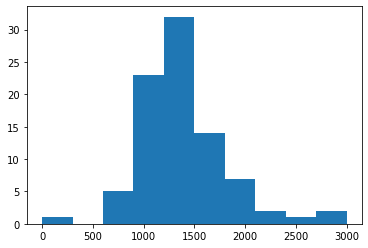

In [175]:
plt.hist(home_sizes1)

(array([71., 14.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  688.27586208,  2728.0982759 ,  4767.92068972,  6807.74310353,
         8847.56551735, 10887.38793117, 12927.21034499, 14967.03275881,
        17006.85517262, 19046.67758644, 21086.50000026]),
 <BarContainer object of 10 artists>)

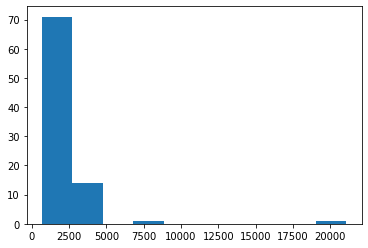

In [176]:
plt.hist(home_sizes2)

In [177]:
home_sizes2.sort_values()

neighborhood
downtown                      688.275862
union_square                  736.923077
van_ness/_civic_center        867.361765
telegraph_hill               1008.180153
nob_hill                     1075.000000
                                ...     
financial_district_south     3798.808823
st._francis_wood             3865.869924
ingleside_terraces           4499.174105
mission_bay                  8681.792903
south_beach                 21086.500000
Length: 87, dtype: float64

In [178]:
home_sizes1.loc[home_sizes1 == 0] = home_sizes2['stonestown']

In [179]:
home_sizes = home_sizes1.copy()

(array([ 4.,  6., 35., 21.,  8.,  7.,  3.,  0.,  1.,  2.]),
 array([ 612.35294118,  851.11764706, 1089.88235294, 1328.64705882,
        1567.41176471, 1806.17647059, 2044.94117647, 2283.70588235,
        2522.47058824, 2761.23529412, 3000.        ]),
 <BarContainer object of 10 artists>)

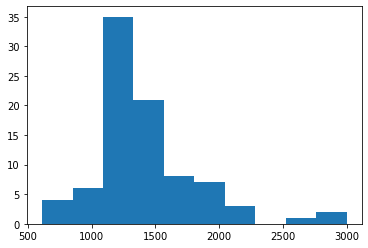

In [180]:
plt.hist(home_sizes)

In [162]:
neighborhoods['home_sizes'] = home_sizes

In [164]:
neighborhoods['$/sf'] = neighborhoods['home_prices_jan07'] / neighborhoods['home_sizes']

In [167]:
neighborhoods.sort_values('$/sf')

,property_area_in_square_feet,home_prices_jan07,home_sizes,$/sf
neighborhood,,,,
diamond_heights,1898.0,5.796559e+05,1862.000000,311.308199
hunters_point,1219.0,3.837898e+05,1219.000000,314.839869
anza_vista,2650.0,7.540330e+05,1550.000000,486.472907
pine_lake_park,1719.5,8.411835e+05,1719.500000,489.202365
merced_manor,2250.0,1.102557e+06,2250.000000,490.025433
...,...,...,...,...
noe_valley,1689.5,1.146094e+06,1200.000000,955.078716
westwood_highlands,1450.0,1.399414e+06,1450.000000,965.113166
russian_hill,3164.5,1.169982e+06,1198.500000,976.205457


(array([ 2.,  3., 16., 28., 20., 11.,  5.,  1.,  0.,  1.]),
 array([ 311.30819885,  408.32480965,  505.34142046,  602.35803127,
         699.37464208,  796.39125288,  893.40786369,  990.4244745 ,
        1087.4410853 , 1184.45769611, 1281.47430692]),
 <BarContainer object of 10 artists>)

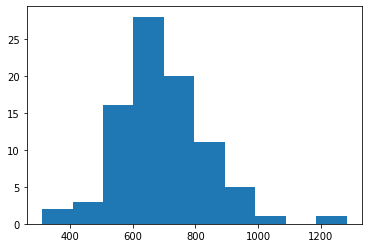

In [168]:
plt.hist(neighborhoods['$/sf'])